In [ ]:
#conda activate tf2, tf2.10
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import os
from utils import *
from glob import glob
try:
    from tensorflow.python.keras.applications import ResNet50
    from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
    from tensorflow.python.keras import backend as K
except:
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
    from tensorflow.keras import backend as K 
    
from time import time


if K.image_data_format() == 'channels_first':
    K.set_image_data_format('channels_last')
print(K.image_data_format())

print(tf.__version__) #2.10.0

In [7]:
################# SET PARAMS ##########################
#layers
block = ['conv2']
LAYER_TYPE = 'act'
MAX_SIDE = 32

#flow stims
scl_factor = 0.5
N_INSTANCES = 3
trial_len = 75//2# n frames
stride = 1

model_name = 'res50_shifted'

## SAMPLING
seed = 0
fmap_samp_method = 'maxFr'
neur_samp_method = 'maxNr'
n_fmaps_to_sample = 40
samples_per_fmap = 50

In [ ]:
############## LOAD MODEL ############################

model = ResNet50(include_top=True, weights='imagenet')
model.layers[-1].activation = tf.keras.activations.relu
model.compile('adam', loss='categorical_crossentropy')
if tf.__version__[0] == '2':
    input_shape = model.layers[0].output_shape[0][1:3]
else:
    input_shape = model.layers[0].output_shape[1:3]

conv_layers = []
act_layers = []
fc_layers = []
current_convs = []
for li,layer in enumerate(model.layers):
    type_name = str(type(model.layers[li]))
    if 'Conv2D' in type_name:
        current_convs.append((li,layer.name,layer))

    elif 'Activation' in type_name:
        #print('-',[(lci,lcname) for lci,lcname,cl in current_convs])

        act_layers.append((li,layer.name,layer))
        #print('*',li,layer.name)
        for lc,_,cl in current_convs:
            assert layer.output.shape.as_list() == cl.output.shape.as_list()
        conv_layers.append(current_convs)
        current_convs = []
    elif 'Dense' in type_name:
        fc_layers.append((li,layer.name,layer))

In [11]:
############# LOAD FLOW STIM FRAMES #################


orig_shape = (800,600)
scl_factor = 0.5

mydirs = list(map(str,range(0,360,45)))
categories = ['grat_W12','grat_W1','grat_W2',
              'neg1dotflow_D1_bg','neg3dotflow_D1_bg','neg1dotflow_D2_bg','neg3dotflow_D2_bg',
              'pos1dotflow_D1_bg','pos3dotflow_D1_bg','pos1dotflow_D2_bg','pos3dotflow_D2_bg']

topdir = 'flowstims'
NDIRS = len(mydirs)
tot_stims = len(categories)*NDIRS
print('tot_stims',tot_stims,flush=True)
frames_per_stim = (trial_len//stride)
print('frames_per_stim',frames_per_stim)

flow_datasets = createFlowDataset(categories, topdir, mydirs, orig_shape, input_shape, scl_factor, N_INSTANCES, trial_len, stride)

tot_stims 88
frames_per_stim 37
*INSTANCE 0 ...........
*INSTANCE 1 ...........
*INSTANCE 2 ...........


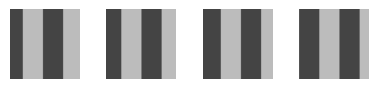

In [31]:
#show example of sequence of frames generated for a stimulus trial
n_frames_to_show = 4
interval = 8

f, axes = subps(1,n_frames_to_show, 1, 1)
for i in range(n_frames_to_show):
    ax = axes[i]
    ax.imshow(flow_datasets[0][i*interval].reshape(input_shape), vmin=0, vmax=255, cmap='gray')
    ax.axis('off')
    
f.tight_layout()
plt.show()

In [5]:
############# GET LAYERS #################


block_test = lambda name: any([b in name for b in block])
block_is = [li for li,lrs in enumerate(conv_layers) if any([block_test(lname) for _,lname,_ in lrs])]

block_layers = [(li,l) for li,l in enumerate(model.layers) if block_test(l.name)]
my_act_layers = [act_layers[li] for li in block_is]

if LAYER_TYPE == 'conv':
    mylayers =[]
    for li in block_is:
        mylayers += conv_layers[li]
    my_conv_ls = [[l] for l in mylayers]
    
elif LAYER_TYPE == 'act':
    mylayers = my_act_layers
    my_conv_ls = [conv_layers[li] for li in block_is]
    
elif LAYER_TYPE == 'dense':
    mylayers = fc_layers
    my_conv_ls = None
else:
    raise ValueError
    
layers_to_use = [l for li,lname,l in mylayers]
Nlayers = len(layers_to_use)

input_layer = model.layers[0]

if LAYER_TYPE == 'dense':
    chan_idx = 1
    all_layer_totfmaps = [lconv.output.shape.as_list()[chan_idx] for lconv in layers_to_use]
    all_layer_spacedims = [[1,1] + [all_layer_totfmaps[li]] for li,lconv in enumerate(layers_to_use)]
    out_pads = None
else:
    out_pads = [max(1,(layers_to_use[li].output.shape.as_list()[1] - MAX_SIDE)//2 ) for li in range(len(layers_to_use))]

    chan_idx = 3
    img_idxs = [1,2]
    all_layer_totfmaps = [lconv.output.shape.as_list()[chan_idx] for lconv in layers_to_use]
    all_layer_spacedims = [list(np.array(layers_to_use[li].output.shape.as_list())[img_idxs]-2*out_pads[li]) + \
                           [all_layer_totfmaps[li]] for li,lconv in enumerate(layers_to_use)]

all_layer_nunits = [np.prod(lspcd) for lspcd in all_layer_spacedims]

for li,l in enumerate(layers_to_use):
    
    print(f'{l.name}: {all_layer_totfmaps[li]} fmaps')
    print('  spacedims',all_layer_spacedims[li])
    print('  Total units:',all_layer_nunits[li],flush=True)

conv2_block1_1_relu: 64 fmaps
  spacedims [32, 32, 64]
  Total units: 65536
conv2_block1_2_relu: 64 fmaps
  spacedims [32, 32, 64]
  Total units: 65536
conv2_block1_out: 256 fmaps
  spacedims [32, 32, 256]
  Total units: 262144
conv2_block2_1_relu: 64 fmaps
  spacedims [32, 32, 64]
  Total units: 65536
conv2_block2_2_relu: 64 fmaps
  spacedims [32, 32, 64]
  Total units: 65536
conv2_block2_out: 256 fmaps
  spacedims [32, 32, 256]
  Total units: 262144
conv2_block3_1_relu: 64 fmaps
  spacedims [32, 32, 64]
  Total units: 65536
conv2_block3_2_relu: 64 fmaps
  spacedims [32, 32, 64]
  Total units: 65536
conv2_block3_out: 256 fmaps
  spacedims [32, 32, 256]
  Total units: 262144


In [8]:
####################### COMPUTE ################

all_layer_outs = K.function(inputs=[input_layer.input], 
                          outputs=[lconv.output for lconv in layers_to_use])

TOL = 0
layer_outputs = {}


n_orig_imgs = tot_stims
n_shifts = frames_per_stim
n_shifted_imgs = n_orig_imgs * n_shifts


#batches for imgs and shifts
maxBatchsize = 32 #max n of images to be used as input simultaneously (prevent memory crashes)

nBatches = int(np.ceil(n_shifted_imgs/float(maxBatchsize)))

print('tot # of images:',n_orig_imgs,'*',n_shifts,'=',n_shifted_imgs)
print('batchsize',maxBatchsize,'-- # of batches:',nBatches)

def reshape_flow_img(raveled_1chan_img):
    return np.moveaxis(np.tile(raveled_1chan_img.reshape(input_shape),(3,1,1)),0,-1)


layer_outputs = []
layer_output = []
for li in range(len(layers_to_use)):
    layer_outputs.append(np.zeros([n_shifted_imgs] + all_layer_spacedims[li], dtype='float32'))
    layer_output.append(None)
for insti in range(N_INSTANCES):
    extX = flow_datasets[insti]
    assert extX.shape[0] == n_shifted_imgs

    print('INSTANCE',insti)
    start0 = time()
    for bb in range(nBatches):
        start = time()
        print(bb,end=' ',flush=True)

        #grab imgs and reshape 'em

        batch = np.array([preprocess_input(reshape_flow_img(im)) \
             for im in extX[bb*maxBatchsize:(bb+1)*maxBatchsize]])

        batch_output = all_layer_outs([batch])
        print('(%.1fs) ' % (time()-start),end='',flush=True)
        
        for li in range(len(layers_to_use)):
            hh, ww = all_layer_spacedims[li][:2]

            if out_pads is None:
                assert batch_output[li].ndim == 2
                l_batch_output = batch_output[li][:,None,None,:]
                
            else:
                l_batch_output = batch_output[li][:,out_pads[li]:hh+out_pads[li],out_pads[li]:ww+out_pads[li],:]
            if bb == 0:
                layer_output[li] = l_batch_output
            else:
                #append to current output
                layer_output[li] = np.concatenate([layer_output[li],l_batch_output])


    for li in range(len(layers_to_use)):
        layer_outputs[li] += layer_output[li]
    print(' Tot time = %.1f' % (time() - start0),flush=True)
for li in range(len(layers_to_use)):
    layer_outputs[li] /= N_INSTANCES

tot # of images: 88 * 37 = 3256
batchsize 32 -- # of batches: 102
INSTANCE 0
0 (3.0s) 1 (0.6s) 2 (0.6s) 3 (0.6s) 4 (0.5s) 5 (0.5s) 6 (0.5s) 7 (0.6s) 8 (0.6s) 9 (0.5s) 10 (0.6s) 11 (0.6s) 12 (0.6s) 13 (0.5s) 14 (0.5s) 15 (0.5s) 16 (0.5s) 17 (0.5s) 18 (0.5s) 19 (0.5s) 20 (0.5s) 21 (0.5s) 22 (0.5s) 23 (0.5s) 24 (0.5s) 25 (0.5s) 26 (0.5s) 27 (0.5s) 28 (0.5s) 29 (0.5s) 30 (0.5s) 31 (0.5s) 32 (0.5s) 33 (0.5s) 34 (0.5s) 35 (0.5s) 36 (0.5s) 37 (0.5s) 38 (0.5s) 39 (0.5s) 40 (0.6s) 41 (0.4s) 42 (0.5s) 43 (0.5s) 44 (0.5s) 45 (0.5s) 46 (0.5s) 47 (0.5s) 48 (0.5s) 49 (0.5s) 50 (0.5s) 51 (0.5s) 52 (0.5s) 53 (0.5s) 54 (0.5s) 55 (0.5s) 56 (0.5s) 57 (0.4s) 58 (0.5s) 59 (0.4s) 60 (0.5s) 61 (0.5s) 62 (0.5s) 63 (0.5s) 64 (0.5s) 65 (0.5s) 66 (0.5s) 67 (0.5s) 68 (0.5s) 69 (0.6s) 70 (0.5s) 71 (0.5s) 72 (0.5s) 73 (0.5s) 74 (0.5s) 75 (0.5s) 76 (0.5s) 77 (0.5s) 78 (0.6s) 79 (0.5s) 80 (0.5s) 81 (0.5s) 82 (0.5s) 83 (0.5s) 84 (0.5s) 85 (0.5s) 86 (0.5s) 87 (0.5s) 88 (0.5s) 89 (0.5s) 90 (0.5s) 91 (0.5s) 92 (0.5s) 93 

In [10]:
################### SUMMARIZE ACTIVITY ###########

print('Activities per img:',end=' ')
for li in range(len(layers_to_use)):
    print(li,end='',flush=True)
    layer_output_ = layer_outputs[li].copy()
    layer_output_[layer_output_ < 0] = 0
    

    nfmaps = layer_output_.shape[3]
    orig_per_img_output = np.moveaxis(layer_output_.copy(),-1,1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    orig_per_img_output = np.moveaxis(orig_per_img_output,1,-1)

    #normalize each img by the max, to prevent results being dominated by a few highly-activating images
    layer_output_ /= from0to1(layer_output_.max((1,2,3),keepdims=1))

    per_img_output = np.moveaxis(layer_output_,-1,1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    per_img_output = np.moveaxis(per_img_output,1,-1)
    

    #get the avg response (across time) of a neuron to a particular stim dir
    #then, compute the max or mean across these
    tot_n_neurons = np.prod(layer_output_.shape[1:])

    
    neurons_maxs = np.zeros(per_img_output.shape[1:3])
    neurons_means = np.zeros(per_img_output.shape[1:3])#np.zeros(tot_n_neurons)

    for imi in range(n_orig_imgs):
        im_avgs = per_img_output[imi].mean(2) #avging across time
        neurons_maxs = np.max([neurons_maxs,im_avgs],0)
        neurons_means += im_avgs
    neurons_means /= n_orig_imgs

    idxs = neurons_maxs.mean(1).argsort()

    if li == 0:
        all_neurons_maxs = neurons_maxs
        all_neurons_means = neurons_means
        all_per_img_output = orig_per_img_output
    else:
        all_neurons_maxs = np.concatenate([all_neurons_maxs, neurons_maxs],0)
        all_neurons_means = np.concatenate([all_neurons_means, neurons_means],0)
        all_per_img_output = np.concatenate([all_per_img_output, orig_per_img_output],1)



Activities per img: 012345678

In [11]:
############# SAMPLE NEURONS ###########

nfmaps,n_neurons_per_fmap = all_neurons_maxs.shape
layer_is_per_fmap = np.concatenate([li*np.ones(nfs) for li,nfs in enumerate(all_layer_totfmaps)])
np.random.seed(seed)

maxsmean = all_neurons_maxs.mean(1)
n_fmaps_to_sample_ = min(n_fmaps_to_sample, (~np.isclose(maxsmean,0)).sum())
if fmap_samp_method == 'maxFr':
    top_fmaps = np.random.choice(range(nfmaps),n_fmaps_to_sample_,False,maxsmean/maxsmean.sum())
else:
    raise ValueError
    
#pick active neurons in each of these fmaps
sampled_neurons = []

samples_per_fmap = min(samples_per_fmap,all_neurons_means.shape[1])
for fi in top_fmaps:
    if neur_samp_method == 'maxNr':
        neuron_vals = all_neurons_maxs[fi]
        samples_per_fmap_ = min(samples_per_fmap, (~np.isclose(neuron_vals,0)).sum())
        top_nis = np.random.choice(range(n_neurons_per_fmap),samples_per_fmap_,False,neuron_vals/neuron_vals.sum())
    else:
        raise ValueError
    sampled_neurons += list(fi*n_neurons_per_fmap + top_nis)
sampled_neurons = np.array(sampled_neurons)
n_neurons_to_pick = len(sampled_neurons)
print(n_neurons_to_pick)

2000


In [12]:
######### BUILD TENSOR ##########
###BUILD TENSOR from psts

#helper ftn
def get_neuron_pos(ni):
    """from sampled indices ni, get original indices back (fmap, posi, posj, raveled_idx)"""
    fi = ni // n_neurons_per_fmap
    li = layer_is_per_fmap[fi]
    ij = ni % n_neurons_per_fmap
    ii = ij // ww
    jj = ij % ww
    return li,fi,ii,jj,ij

assert n_orig_imgs//NDIRS == len(categories)

tensorX = np.zeros((n_neurons_to_pick,len(categories),NDIRS,n_shifts))
neurons_used = np.empty((n_neurons_to_pick,5),dtype='int')


#collect psts for those sampled neurons
for nii,ni in enumerate(sampled_neurons):
    
    li, fi, ii, jj, posi = get_neuron_pos(ni)
    neurons_used[nii] = [li, fi, ii, jj, posi]
    

    for cati in range(len(categories)):
        
        pst = all_per_img_output[cati*NDIRS:(cati+1)*NDIRS,fi,posi,:]
        tensorX[nii,cati] = pst
        


SUFFIX = f"{model_name}_{LAYER_TYPE}_i{N_INSTANCES}_n{n_neurons_to_pick}_w{ww}_SCL{str(scl_factor).replace('.','_')}_TL{trial_len}_{'_'.join(block)}_{fmap_samp_method}_{neur_samp_method}"
if seed > 0:
    SUFFIX += f'_seed{seed}'

print(SUFFIX)

res50_shifted_act_i3_n2000_w32_SCL0_5_TL37_conv2_maxFr_maxNr


In [ ]:
np.save(f'tensor4d_{SUFFIX}.npy',tensorX)
print(f'tensor4d_{SUFFIX}.npy','Saved.')

np.save(f'neurons_used_{SUFFIX}.npy',neurons_used)
print(f'neurons_used_{SUFFIX}.npy','Saved.')